# Train / load pretrained models

In [75]:
train_general = False

train_gk = False
train_def = False
train_mid = False
train_fwd = False

# Google Colab / Kaggle / PC

In [76]:
mode = "Colab"

In [77]:
import os

if mode == "Colab":
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.chdir("/content/gdrive/My Drive/FPL_ML")
    TRAIN_PATH = "data/final_dataset.csv"
if mode == "PC":
    os.chdir("D:\PulpitE\FPL_ML")
    TRAIN_PATH = "data/final_dataset.csv"
if mode == "Kaggle":
    TRAIN_PATH = "/kaggle/input/fpl-dataset/final_dataset.csv"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Imports

In [78]:
import pandas as pd

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms
from torchvision.transforms import ToTensor

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np
import random

# Constants and seeds

In [79]:
# FIXTURES_IN_SAMPLE
FIS = 8

# FIXTURES_FOR_PLAYER - minimal number of gameweeks required for a player
FFP = 15

FIRST_TRAIN_GW = 9
LAST_TRAIN_GW = 20

FIRST_VALID_GW = 21
LAST_VALID_GW = 21

# NEXT_GAMEWEEK = 22
# LAST_GAMEWEEK = NEXT_GAMEWEEK - 1

In [80]:
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_all_seeds(42)

# Device

In [81]:
device = torch.device("cuda")
# device = torch.device('mps')
# device = torch.device('cpu')

# Getting data and choosing features

In [82]:
df = pd.read_csv('data/final_dataset.csv')

In [83]:
# remembering original dataframes
df_original = df

df_gk_original = df[df["FPL position"] == "GK"]
df_def_original = df[df["FPL position"] == "DEF"]
df_mid_original = df[df["FPL position"] == "MID"]
df_fwd_original = df[df["FPL position"] == "FWD"]

In [84]:
# df_original.columns

In [85]:
info = ["Name", "GW", "FPL position"]
other = ["LSTM"]
features = ["Min", "Gls", "Ast", "Sh", "SoT", "xG", "npxG", "xAG", "SCA", "GCA", "CS", "CrdY", "CrdR", "Opp rating", "Team Score", "Opp Score", "Was Home"]
to_predict = ["Total Points"]

In [86]:
df = df[info + features + to_predict]
df[features + to_predict] = df[features + to_predict].astype("float32")

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [87]:
df.shape

(7457, 21)

In [88]:
# removing NaN rows and players that appear less than 15 times
df = df.dropna()
grouped = df.groupby('Name')

# taking only players with at least FFP matches in logs
df = grouped.filter(lambda x: len(x) >= FFP)

In [89]:
df.shape

(5771, 21)

In [90]:
# df.head(20)

In [91]:
last_names = df["Name"].unique()

# DF to DataLoader

In [92]:
df_train = df[df["GW"] <= LAST_TRAIN_GW]
df_valid = df

# gk, def, mid, fwd
df_gk_train = df[(df["FPL position"] == "GK") & (df["GW"] <= LAST_TRAIN_GW)]
df_gk_valid = df[(df["FPL position"] == "GK") ]

df_def_train = df[(df["FPL position"] == "DEF") & (df["GW"] <= LAST_TRAIN_GW)]
df_def_valid = df[(df["FPL position"] == "DEF") ]

df_mid_train = df[(df["FPL position"] == "MID") & (df["GW"] <= LAST_TRAIN_GW)]
df_mid_valid = df[(df["FPL position"] == "MID") ]

df_fwd_train = df[(df["FPL position"] == "FWD") & (df["GW"] <= LAST_TRAIN_GW)]
df_fwd_valid = df[(df["FPL position"] == "FWD")]

In [93]:
def init_index_table(df):
    names = df["Name"].unique()
    result_dict = {}
    
    current_index = 0
    player_index = 0
    
    for name in names:
        sample_index = 0
        samples_for_names = df[df["Name"] == name].shape[0] - FIS
        for i in range(samples_for_names):
            result_dict[current_index] = [player_index, sample_index]
            current_index += 1
            sample_index += 1
        player_index += 1
    
    return result_dict

In [94]:
class PandasDataset(Dataset):
    def __init__(self, dataframe, starting_gw, ending_gw):
        self.dataframe = dataframe
        self.names = dataframe["Name"].unique()
        
        self.starting_gw = starting_gw
        self.ending_gw = ending_gw
        self.cut_unused_rows()
        self.length = self.calculate_length()

        self.index_table = init_index_table(self.dataframe)
        self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

    def cut_unused_rows(self):
        for name in self.names:
            df_name = self.dataframe[self.dataframe["Name"] == name]
            name_length = df_name.shape[0]
            # print("NAME LENGTH", name, name_length, FIS + 1)
            if name_length >= FIS + 1:
                try:
                    first_index = df_name.index.tolist()[0]
                except IndexError:
                    first_index = None

                try:
                    last_index = max(FIS, df_name.index[df_name['GW'] < self.starting_gw].tolist()[-1]) - FIS
                except:
                    last_index = None

                # print("FIRST LAST INDEX", name, first_index, last_index)
                if first_index != None and last_index != None:
                    # print("WYCIETO", name, range(first_index, last_index + 1))
                    self.dataframe = self.dataframe.drop(range(first_index, last_index + 1))
            else:
                # print("DROPPING", name, [df_name.index.tolist()])
                self.dataframe = self.dataframe.drop([df_name.index.tolist()])
                

            # print("CUTTING", name, first_index, last_index, name_length)
            # print("CUT2", df_name.index[df_name['GW'] < self.starting_gw].tolist())
            # print(self.dataframe.shape)
            # print("")

    def calculate_length(self):
        length = 0
        for name in self.names:
            # print(name, (self.dataframe[self.dataframe["Name"] == name].shape[0] - FIS))
            length += (self.dataframe[self.dataframe["Name"] == name].shape[0] - FIS)
        return length

    def get_items_info(self):
        gws = []
        for i in range(self.__len__()):
            player_id, sample_id = self.index_table[i]
            name = self.names[player_id]
            gw = self.dataframe[self.dataframe["Name"] == name].iloc[(sample_id + FIS)]["GW"]
            gws.append(gw)
        return pd.DataFrame(gws)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # print(idx)
        player_id, sample_id = self.index_table[idx]
        name = self.names[player_id]
        # print(name)
        # print("GETITEM DF", name, player_id, sample_id)

        features = self.dataframe[self.dataframe["Name"] == name]
        # print(self.dataframe[self.dataframe["Name"] == name])
        # print(features[sample_id: (sample_id + 4)])
        features = features[sample_id: (sample_id + FIS)].drop(columns=info).values[:, :-1]
        # print(features)
        # print(features)
        # print(type(features))
        # print(self.dataframe[self.dataframe["Name"] == name].values[:, -1])
        # print(type(self.dataframe[self.dataframe["Name"] == name].values[:, -1]))
        # target = self.dataframe[self.dataframe["Name"] == name].values[:, -1]
        # target = target.astype(np.float32)
        # target = torch.from_numpy(target)
        # print("GETITEM", idx, player_id, sample_id, name)
        target = np.float32(self.dataframe[self.dataframe["Name"] == name].values[(sample_id + FIS), -1])
        # print(name, idx, target, sample_id)
        # print(type(target))
        return features, target

In [95]:
dataset_general_train = PandasDataset(df_train, FIRST_TRAIN_GW, LAST_TRAIN_GW)
dataset_general_valid = PandasDataset(df_valid, FIRST_VALID_GW, LAST_VALID_GW)

dataset_gk_train = PandasDataset(df_gk_train, FIRST_TRAIN_GW, LAST_TRAIN_GW)
dataset_gk_valid = PandasDataset(df_gk_valid, FIRST_VALID_GW, LAST_VALID_GW)

dataset_def_train = PandasDataset(df_def_train, FIRST_TRAIN_GW, LAST_TRAIN_GW)
dataset_def_valid = PandasDataset(df_def_valid, FIRST_VALID_GW, LAST_VALID_GW)

dataset_mid_train = PandasDataset(df_mid_train, FIRST_TRAIN_GW, LAST_TRAIN_GW)
dataset_mid_valid = PandasDataset(df_mid_valid, FIRST_VALID_GW, LAST_VALID_GW)

dataset_fwd_train = PandasDataset(df_fwd_train, FIRST_TRAIN_GW, LAST_TRAIN_GW)
dataset_fwd_valid = PandasDataset(df_fwd_valid, FIRST_VALID_GW, LAST_VALID_GW)

In [96]:
dataset_gk_train.__len__(), dataset_gk_valid.__len__()

(193, 25)

In [97]:
dataset_def_train.__len__(), dataset_def_valid.__len__()

(725, 100)

In [98]:
dataset_mid_train.__len__(), dataset_mid_valid.__len__()

(968, 123)

In [99]:
dataset_fwd_train.__len__(), dataset_fwd_valid.__len__()

(258, 30)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9185ad370>]],
      dtype=object)

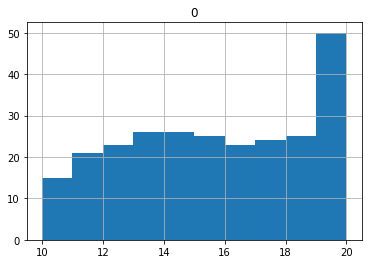

In [100]:
dataset_fwd_train.get_items_info().hist()

In [101]:
batch_size = 16

In [102]:
dataloader_general_train = DataLoader(dataset_general_train, batch_size=batch_size, shuffle=False)
dataloader_general_valid = DataLoader(dataset_general_valid, batch_size=batch_size, shuffle=False)

dataloader_gk_train = DataLoader(dataset_gk_train, batch_size=batch_size, shuffle=False)
dataloader_def_train = DataLoader(dataset_def_train, batch_size=batch_size, shuffle=False)
dataloader_mid_train = DataLoader(dataset_mid_train, batch_size=batch_size, shuffle=False)
dataloader_fwd_train = DataLoader(dataset_fwd_train, batch_size=batch_size, shuffle=False)

dataloader_gk_valid = DataLoader(dataset_gk_valid, batch_size=batch_size, shuffle=False)
dataloader_def_valid = DataLoader(dataset_def_valid, batch_size=batch_size, shuffle=False)
dataloader_mid_valid = DataLoader(dataset_mid_valid, batch_size=batch_size, shuffle=False)
dataloader_fwd_valid = DataLoader(dataset_fwd_valid, batch_size=batch_size, shuffle=False)

In [103]:
len(dataloader_general_train), len(dataloader_gk_train), len(dataloader_def_train), len(dataloader_mid_train), len(dataloader_fwd_train)

(134, 13, 46, 61, 17)

In [104]:
len(dataloader_general_valid), len(dataloader_gk_valid), len(dataloader_def_valid), len(dataloader_mid_valid), len(dataloader_fwd_valid)

(18, 2, 7, 8, 2)

# LSTM Model

In [105]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMNetwork, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.transpose(x, 0, 1)
        # x = x.view(-1, batch_size)
        # x = torch.transpose(x, 0, 1)
        # print("FOR", x.shape)
        # print(x.shape)
        # print(x.shape)
        out, _ = self.lstm(x)
        # print(out.shape)
        out = self.fc(out[-1])
        return out

# Training loops

In [106]:
criterion = nn.MSELoss()

In [107]:
def train_net(net, num_epochs, dataloader_train, dataloader_valid, optimizer):
    if len(dataloader_train) <= 0:
        print("Dataloader has no elements")
        return []

    best_model = None
    best_val_loss = None

    loss_history_train = []
    loss_history_valid = []

    for epoch in range(num_epochs):
        running_loss_train = 0
        running_loss_valid = 0

        # training
        for i, (inputs, targets) in enumerate(dataloader_train):
            inputs = torch.flatten(inputs, 1, 2)
            inputs = inputs.unsqueeze(2).to(device)
            targets = targets.to(device)
            # print("INPUTS", inputs.shape)
            # print("TARGETS", targets.shape)
            # print(targets)
            optimizer.zero_grad()
            outputs = net(inputs).flatten().to(device)
            # print("OUTPUTS", outputs.shape)
            loss = criterion(outputs, targets)
            running_loss_train += loss.item()
            loss.backward()
            optimizer.step()

        with torch.no_grad():
          # valid
          for i, (inputs, targets) in enumerate(dataloader_valid):
              inputs = torch.flatten(inputs, 1, 2)
              inputs = inputs.unsqueeze(2).to(device)
              targets = targets.to(device)
              # print("INPUTS", inputs.shape)
              # print("TARGETS", targets.shape)
              # print(targets)
              optimizer.zero_grad()
              outputs = net(inputs).flatten().to(device)
              # print("OUTPUTS", outputs.shape)
              loss = criterion(outputs, targets)
              running_loss_valid += loss.item()

        epoch_valid_loss = running_loss_valid / len(dataloader_valid)

        loss_history_train.append(running_loss_train / len(dataloader_train))
        loss_history_valid.append(epoch_valid_loss)

        if not best_model or epoch_valid_loss < best_val_loss:
            best_model = net
            best_val_loss = epoch_valid_loss


        if epoch % 5 == 0:
            print(f'Epoch {epoch} Train: {running_loss_train / len(dataloader_train)} Valid: {running_loss_valid / len(dataloader_valid)}')
    
    return loss_history_train, loss_history_valid, best_model

In [108]:
def plot_loss_history(loss_history_train, loss_history_valid):
    plt.plot(loss_history_train, color='blue', label='Training Loss')
    plt.plot(loss_history_valid, color='orange', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## Training loop - general net

In [109]:
net = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)
if not train_general:
    net.load_state_dict(torch.load('models/best/best_lstm_general.pt'))
    best_model_general = net

In [110]:
%%time
if train_general:
    optimizer = optim.Adam(net.parameters(), lr=0.005)
    loss_history_train, loss_history_valid, best_model_general = train_net(net, 10, dataloader_general_train, dataloader_general_valid, optimizer)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


In [111]:
if train_general:
    plot_loss_history(loss_history_train, loss_history_valid)

## Training loop - goalkeeper net

In [112]:
net_gk = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)
if not train_gk:
    net_gk.load_state_dict(torch.load('models/best/best_lstm_gk.pt'))
    best_model_gk = net_gk

In [113]:
%%time
if train_gk:
    optimizer_gk = optim.Adam(net_gk.parameters(), lr=0.01)
    loss_history_gk_train, loss_history_gk_valid, best_model_gk = train_net(net_gk, 5, dataloader_gk_train, dataloader_gk_valid, optimizer_gk)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.72 µs


In [114]:
if train_gk:
    plot_loss_history(loss_history_gk_train, loss_history_gk_valid)

## Training loop - defender net

In [115]:
net_def = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)
if not train_def:
    net_def.load_state_dict(torch.load('models/best/best_lstm_def.pt'))
    best_model_def = net_def

In [116]:
%%time
if train_def:
    optimizer_def = optim.Adam(net_def.parameters(), lr=0.005)
    loss_history_def_train, loss_history_def_valid, best_model_def = train_net(net_def, 5, dataloader_def_train, dataloader_def_valid, optimizer_def)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


In [117]:
if train_def:    
    plot_loss_history(loss_history_def_train, loss_history_def_valid)

## Training loop - midfielder net

In [118]:
net_mid = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)
if not train_mid:
    net_mid.load_state_dict(torch.load('models/best/best_lstm_mid.pt'))
    best_model_mid = net_mid

In [119]:
%%time
if train_mid:
    optimizer_mid = optim.Adam(net_mid.parameters(), lr=0.005)
    loss_history_mid_train, loss_history_mid_valid, best_model_mid = train_net(net_mid, 30, dataloader_mid_train, dataloader_mid_valid, optimizer_mid)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


In [120]:
if train_mid:
    plot_loss_history(loss_history_mid_train, loss_history_mid_valid)

## Training loop - forward net

In [121]:
net_fwd = LSTMNetwork(1, 8, 2, 1, dropout=0.5).to(device)
if not train_fwd:
    net_fwd.load_state_dict(torch.load('models/best/best_lstm_fwd.pt'))
    best_model_fwd = net_fwd

In [149]:
%%time
if train_fwd:
    optimizer_fwd = optim.Adam(net_fwd.parameters(), lr=0.0001)
    loss_history_fwd_train, loss_history_fwd_valid, best_model_fwd = train_net(net_fwd, 1500, dataloader_fwd_train, dataloader_fwd_valid, optimizer_fwd)

Epoch 0 Train: 7.809520816101747 Valid: 12.609905242919922
Epoch 5 Train: 7.912437745753457 Valid: 13.177128314971924
Epoch 10 Train: 7.777547497959698 Valid: 12.084552764892578
Epoch 15 Train: 7.72531617213698 Valid: 12.475408554077148
Epoch 20 Train: 7.785195931353989 Valid: 12.436337947845459
Epoch 25 Train: 7.587983311975703 Valid: 12.961256980895996
Epoch 30 Train: 7.826092095936046 Valid: 13.01713228225708
Epoch 35 Train: 7.761821967713973 Valid: 13.466744899749756
Epoch 40 Train: 7.53772047950941 Valid: 12.274722576141357
Epoch 45 Train: 7.805465398465886 Valid: 12.98293399810791
Epoch 50 Train: 7.491556397693999 Valid: 12.847684860229492
Epoch 55 Train: 7.63367563661407 Valid: 12.89367151260376
Epoch 60 Train: 7.571826919475022 Valid: 13.024363040924072
Epoch 65 Train: 7.785777205930037 Valid: 13.056885242462158
Epoch 70 Train: 7.633624942863689 Valid: 13.19374132156372
Epoch 75 Train: 7.663119546630803 Valid: 13.167367458343506
Epoch 80 Train: 7.859812012490104 Valid: 12.61832

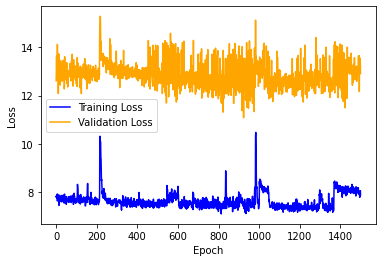

In [150]:
if train_fwd:
    plot_loss_history(loss_history_fwd_train, loss_history_fwd_valid)

# Saving models to files

In [124]:
# general model
torch.save(net.state_dict(), 'models/regular/lstm_general.pt')
torch.save(best_model_general.state_dict(), 'models/best/best_lstm_general.pt')

# positional models
if train_gk:
    torch.save(net_gk.state_dict(), 'models/regular/lstm_gk.pt')
    torch.save(best_model_gk.state_dict(), 'models/best/best_lstm_gk.pt')

if train_def:
    torch.save(net_def.state_dict(), 'models/regular/lstm_def.pt')
    torch.save(best_model_def.state_dict(), 'models/best/best_lstm_def.pt')

if train_mid:
    torch.save(net_mid.state_dict(), 'models/regular/lstm_mid.pt')
    torch.save(best_model_mid.state_dict(), 'models/best/best_lstm_mid.pt')

if train_fwd:
    torch.save(net_fwd.state_dict(), 'models/regular/lstm_fwd.pt')
    torch.save(best_model_fwd.state_dict(), 'models/best/best_lstm_fwd.pt')

# Next GW predictions - general model

In [125]:
def generate_predictions(dataloader_pos, dataset_pos, net_pos, df_original, first_gw):
    index = 0
    predictions_pos = []
    for inputs, target in dataloader_pos:
        inputs = torch.flatten(inputs, 1, 2)
        inputs = inputs.unsqueeze(2).to(device)

        # print("Inputs", inputs)
        # print("Target", target)
        # print("INPUTS", inputs)
        # print(inputs)
        outputs = net_pos(inputs).to(device)
        # print("OUTPUTS", outputs)
        for output in outputs:
            player_id, sample_id = dataset_pos.index_table[index]
            name = dataset_pos.names[player_id]
            points = round(output.item(), 2)
            # print("DFORW NEXT", player_id, sample_id, name, points)
            df_row = df_original[(df_original["Name"] == name) & (df_original["GW"] >= first_gw)].iloc[sample_id]
            # print("DFROW", df_row)
            df_row["Points"] = points
            df_gw = df_row["GW"]
            df_opp = df_row["Opponent"]

            # print("GEN PRED", player_id, sample_id, name, points, df_gw, df_opp)
            
            gw = sample_id + FIS + 1 # wrong
            predictions_pos.append(df_row)
            # df.loc[(df["Name"] == name) & (df["GW"] == gw), "LSTM"] = points
            index += 1
    
    output_df = pd.DataFrame(predictions_pos)
    output_df = output_df.loc[:, ~output_df.columns.str.contains('^Unnamed')]
    return output_df

In [126]:
prediction_columns = ["Name", "GW", "Opponent", "Was Home", "Total Points", "Points"]

In [127]:
predictions = generate_predictions(dataloader_general_valid, dataset_general_valid, net, df_original, FIRST_VALID_GW)

In [128]:
# dataset_general_valid.__getitem__(279)

In [129]:
predictions.sort_values(by=["Points"], ascending = False).head(20)[prediction_columns]

,Name,GW,Opponent,Was Home,Total Points,Points
3401,Brennan-Johnson,21,Bournemouth,0.0,5.0,2.83
6684,Takehiro-Tomiyasu,21,Manchester Utd,1.0,4.0,2.83
4790,Joao-Moutinho,21,Manchester City,0.0,1.0,2.83
7140,Ben-White,21,Manchester Utd,1.0,0.0,2.83
4850,Vitaliy-Mykolenko,21,West Ham,0.0,0.0,2.83
5383,Daniel-Podence,21,Manchester City,0.0,1.0,2.83
3882,Jefferson-Lerma,21,Nott'ham Forest,1.0,2.0,2.82
1917,Gabriel-Dos-Santos,21,Manchester Utd,1.0,1.0,2.82
6943,Ruben-Vinagre,21,West Ham,0.0,0.0,2.82
6959,Carlos-Vinicius,21,Tottenham,1.0,1.0,2.82


In [130]:
# # appending results to original df
# for df_gw, df_opp, name, gw, points in predictions:
#     df_original.loc[(df_original["Name"] == name) & (df["GW"] == gw), "LSTM"] = points

In [131]:
# df_original.to_csv("data/fpl_fbref_elo_lstm.csv")

# Next GW predictions for each position

## Goalkeepers

In [132]:
predictions_gk = generate_predictions(dataloader_gk_valid, dataset_gk_valid, net_gk, df_gk_original, FIRST_VALID_GW)

In [133]:
# results sorted
predictions_gk_sorted = predictions_gk.sort_values(by=["Points"], ascending = False).head(20)
predictions_gk_sorted[prediction_columns]

,Name,GW,Opponent,Was Home,Total Points,Points
5863,Jose-Sa,21,Manchester City,0.0,2.0,3.16
6761,Mark-Travers,21,Nott'ham Forest,1.0,0.0,3.14
391,Alphonse-Areola,21,Everton,1.0,0.0,3.13
731,Asmir-Begovic,21,West Ham,0.0,0.0,3.12
7030,Danny-Ward,21,Brighton,1.0,1.0,3.11
3862,Bernd-Leno,21,Tottenham,1.0,2.0,3.10
4000,Hugo-Lloris,21,Fulham,0.0,9.0,3.10
2252,Lukasz-Fabianski,21,Everton,1.0,6.0,3.10
467,Kepa-Arrizabalaga,21,Liverpool,0.0,9.0,3.10
6011,Robert-Sanchez,21,Leicester City,0.0,1.0,3.09


## Defenders

In [134]:
predictions_def = generate_predictions(dataloader_def_valid, dataset_def_valid, net_def, df_def_original, FIRST_VALID_GW)

In [135]:
# results sorted
predictions_def_sorted = predictions_def.sort_values(by=["Points"], ascending = False).head(20)
predictions_def_sorted[prediction_columns]

,Name,GW,Opponent,Was Home,Total Points,Points
3381,Ben-Johnson,21,Everton,1.0,1.0,2.38
3646,Ezri-Konsa,21,Southampton,0.0,7.0,2.38
2166,Emerson,21,Fulham,0.0,9.0,2.38
1898,Matt-Doherty,21,Fulham,0.0,0.0,2.37
1430,Steve-Cook,21,Bournemouth,0.0,0.0,2.37
6781,Kieran-Trippier,21,Crystal Palace,0.0,8.0,2.37
1183,Jonny-Castro,21,Manchester City,0.0,0.0,2.37
6596,Kenny-Tete,21,Tottenham,1.0,2.0,2.37
2678,Joe-Gomez,21,Chelsea,1.0,7.0,2.37
4667,Tyrone-Mings,21,Southampton,0.0,6.0,2.37


## Midfielders

In [136]:
predictions_mid = generate_predictions(dataloader_mid_valid, dataset_mid_valid, net_mid, df_mid_original, FIRST_VALID_GW)

In [137]:
# results sorted
predictions_mid_sorted = predictions_mid.sort_values(by=["Points"], ascending = False).head(20)
predictions_mid_sorted[prediction_columns]

,Name,GW,Opponent,Was Home,Total Points,Points
3325,Mathias-Jensen,21,Leeds United,0.0,3.0,2.85
2185,Christian-Eriksen,21,Arsenal,0.0,2.0,2.85
2786,Pascal-Gross,21,Leicester City,0.0,2.0,2.85
3269,Daniel-James,21,Tottenham,1.0,0.0,2.85
3297,Vitaly-Janelt,21,Leeds United,0.0,1.0,2.85
3430,Jorginho,21,Liverpool,0.0,3.0,2.85
3728,Adam-Lallana,21,Leicester City,0.0,1.0,2.85
3882,Jefferson-Lerma,21,Nott'ham Forest,1.0,2.0,2.85
3960,Jesse-Lingard,21,Bournemouth,0.0,0.0,2.85
4049,Sean-Longstaff,21,Crystal Palace,0.0,3.0,2.85


## Forwards

In [151]:
predictions_fwd = generate_predictions(dataloader_fwd_valid, dataset_fwd_valid, net_fwd, df_fwd_original, FIRST_VALID_GW)

In [152]:
# results sorted
predictions_fwd_sorted = predictions_fwd.sort_values(by=["Points"], ascending = False).head(30)
predictions_fwd_sorted[prediction_columns]

,Name,GW,Opponent,Was Home,Total Points,Points
3501,Harry-Kane,21,Fulham,0.0,6.0,5.47
2904,Erling-Haaland,21,Wolves,1.0,17.0,5.27
4443,Bryan-Mbeumo,21,Leeds United,0.0,2.0,3.89
7212,Callum-Wilson,21,Crystal Palace,0.0,2.0,3.83
6714,Ivan-Toney,21,Leeds United,0.0,1.0,3.76
4718,Aleksandar-Mitrovic,21,Tottenham,1.0,2.0,3.71
4952,Eddie-Nketiah,21,Manchester Utd,1.0,13.0,3.54
7121,Danny-Welbeck,21,Leicester City,0.0,2.0,3.22
7089,Ollie-Watkins,21,Southampton,0.0,8.0,3.11
2967,Kai-Havertz,21,Liverpool,0.0,2.0,3.10


# Saving predictions to files

In [140]:
predictions_gk_sorted.to_csv("predictions/predictions_gk.csv")
predictions_def_sorted.to_csv("predictions/predictions_def.csv")
predictions_mid_sorted.to_csv("predictions/predictions_mid.csv")
predictions_fwd_sorted.to_csv("predictions/predictions_fwd.csv")

# Predictions for train dataloaders



## General model

In [141]:
train_predictions_general = generate_predictions(dataloader_general_train, dataset_general_train, net, df_original, FIRST_TRAIN_GW)

In [142]:
train_predictions_general.to_csv("predictions/train_predictions_general.csv")

## Positional models

In [143]:
train_predictions_gk = generate_predictions(dataloader_gk_train, dataset_gk_train, net_gk, df_gk_original, FIRST_TRAIN_GW)

In [144]:
train_predictions_def = generate_predictions(dataloader_def_train, dataset_def_train, net_def, df_def_original, FIRST_TRAIN_GW)

In [145]:
train_predictions_mid = generate_predictions(dataloader_mid_train, dataset_mid_train, net_mid, df_mid_original, FIRST_TRAIN_GW)

In [146]:
train_predictions_fwd = generate_predictions(dataloader_fwd_train, dataset_fwd_train, net_fwd, df_fwd_original, FIRST_TRAIN_GW)

In [147]:
train_predictions_gk.to_csv("predictions/train_predictions_gk.csv")
train_predictions_def.to_csv("predictions/train_predictions_def.csv")
train_predictions_mid.to_csv("predictions/train_predictions_mid.csv")
train_predictions_fwd.to_csv("predictions/train_predictions_fwd.csv")

In [148]:
train_predictions_fwd[prediction_columns]

,Name,GW,Opponent,Was Home,Total Points,Points
26,Che-Adams,9,Everton,1.0,5.0,2.66
27,Che-Adams,10,Manchester City,0.0,2.0,1.71
28,Che-Adams,11,West Ham,1.0,2.0,4.21
29,Che-Adams,12,Bournemouth,0.0,6.0,2.76
30,Che-Adams,13,Arsenal,1.0,1.0,1.56
...,...,...,...,...,...,...
7261,Chris-Wood,15,Southampton,0.0,7.0,1.65
7262,Chris-Wood,16,Chelsea,1.0,2.0,1.35
7263,Chris-Wood,17,Leicester City,0.0,8.0,1.28
7264,Chris-Wood,18,Leeds United,1.0,2.0,1.45
